# Определение возраста покупателей

**Описание:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator# < Перенесите сюда исследовательский анализ данных >

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


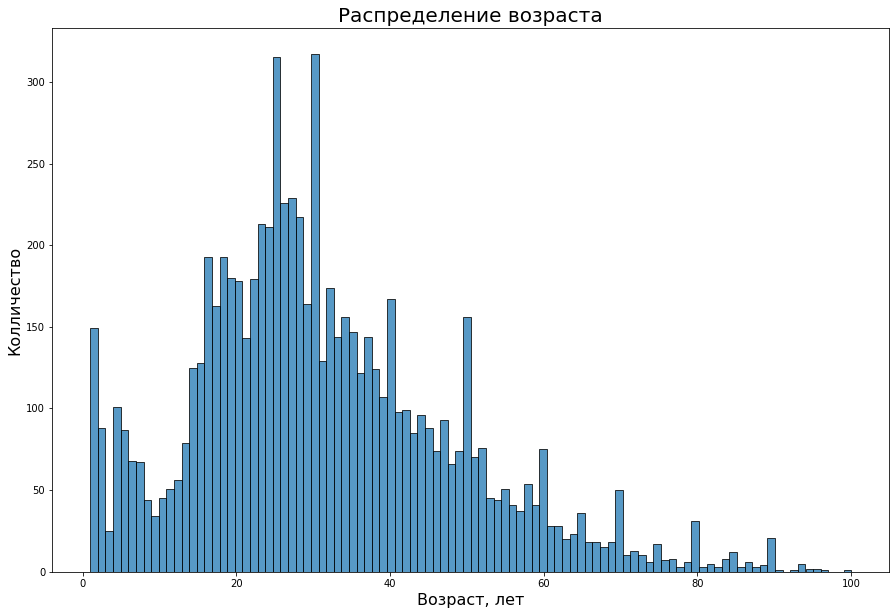

In [6]:
plt.figure(figsize=(15,10))
sns.histplot(labels.real_age, kde = False, bins=100)
plt.title('Распределение возраста', size = 20)
plt.xlabel('Возраст, лет', size = 16)
plt.ylabel('Колличество',  size = 16)
plt.show()

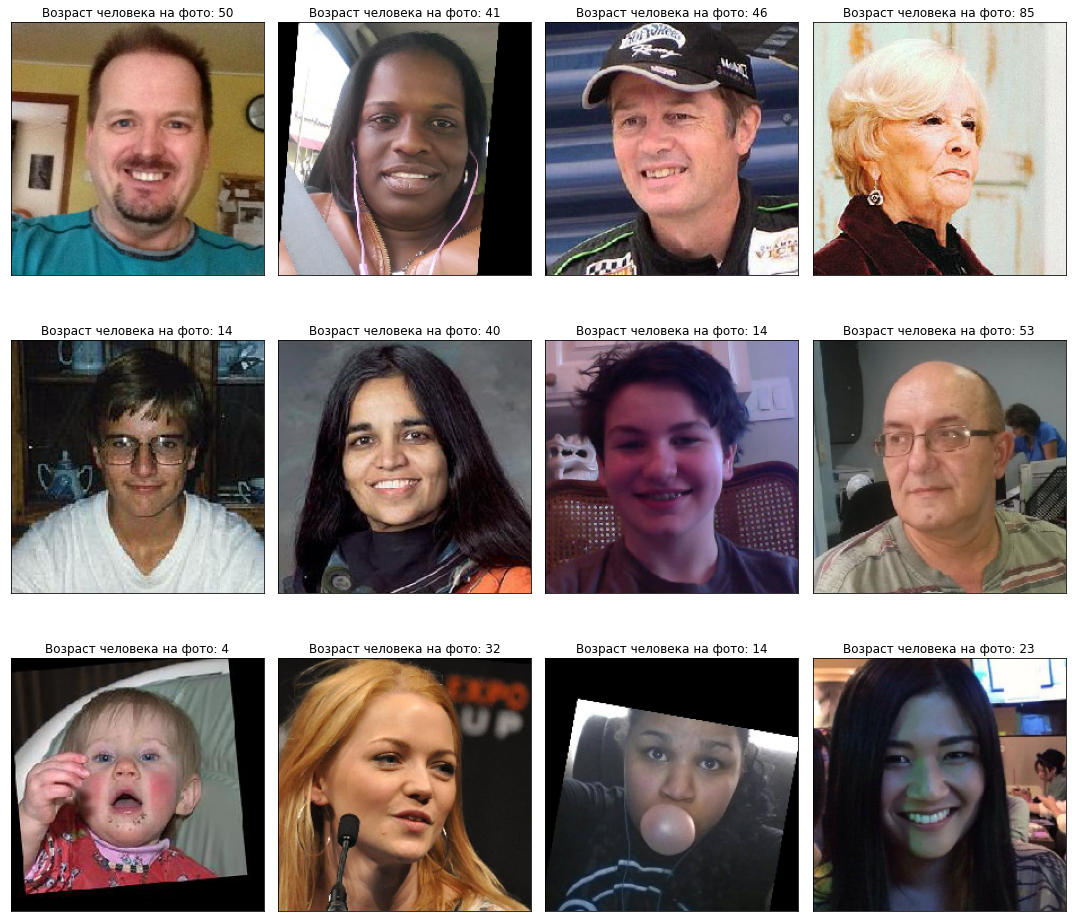

In [7]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст человека на фото: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
plt.show()

### Датасет содержит 7591 фото людей  размеченных по возрасту. Больше всего фотографий людей в возрасте  от 20 до 41 года,  также в датасете присутсвуют  фото  детей и людей пожилого возраста. На примере из нескольких фото мы визуально убедились, что фото размечены корректно.  Качество фото и наличие посторонних предметов на фото может затруднить  обучение модели.

## Обучение модели

### Использовалась модель сверточной нейронной сети построенной на ResNet50, использованно 10 эпох и горизонтальный поворот фотографий.

 Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model
def train_model(model, train_data, test_data, batch_size = None, epochs = 10,
               steps_per_epoch = None, validation_steps = None):
    model.fit(train_data, 
              validation_data = test_data,
              batch_size = batch_size, epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose=2)
    return model 

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-06-13 11:20:47.559830: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-13 11:20:47.893899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 55s - loss: 206.8939 - mae: 10.3934 - val_loss: 781.7167 - val_mae: 22.9499
Epoch 2/10
356/356 - 49s - loss: 85.0510 - mae: 7.0085 - val_loss: 143.4403 - val_mae: 9.2604
Epoch 3/10
356/356 - 46s - loss: 55.8832 - mae: 5.7086 - val_loss: 87.4707 - val_mae: 6.9527
Epoch 4/10
356/356 - 48s - loss: 40.8618 - mae: 4.8379 - val_loss: 68.8181 - val_mae: 6.3498
Epoch 5/10
356/356 - 48s - loss: 32.0437 - mae: 4.3105 - val_loss: 75.6529 - val_mae: 6.6896
Epoch 6/10
356/356 - 47s - loss: 24.9306 - mae: 3.8029 - val_loss: 72.0674 - val_mae: 6.4651
Epoch 7/10
356/356 - 47s - loss: 20.9021 - mae: 3.4805 - val_loss: 67.8098 - val_mae: 6.2537
Epoch 8/10
356/356 - 49s - loss: 16.8053 - mae: 3.1511 - val_loss: 65.8304 - val_mae: 6.0137
Epoch 9/10
356/356 - 48s - loss: 13.5268 - mae: 2.8168 - val_loss: 67.8175 - val_mae: 6.1371
Epoch 10/10
356/356 - 48s - loss: 13.3910 - mae: 2.7685 - val_loss: 63.6796 - val_mae: 5.9743
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 63.6796 - mae: 5.9743
Test MAE: 5.9743
```

## Анализ обученной модели

### Обученная модель позволяет с высокой точностью предсказывать возраст покупателей,  показатель MAE модели 5.97.  Модель не переобучена, так как  значение функции потерь и  MAE уменьшаются как на тренировочном, так и на проверочном наборах.